## TODO:
- Bootstrap models should export to a different folder os it's faster to check model results
- The individual boostrap runs don't matter so we don't really need to retrieve them
- Need a better storage that actually uses a database

In [1]:
from pathlib import Path
import time
import pandas as pd
import geopandas as gpd
import numpy as np
import pickle
from stochopy.optimize import minimize
from tqdm import tqdm
import similaritymeasures
import random
import matplotlib.pyplot as plt
from shapely.ops import Point, MultiLineString, LineString
from importlib import reload
import datetime
from scipy.spatial.distance import directed_hausdorff
np.set_printoptions(suppress=True)
from matplotlib.ticker import MultipleLocator

from bikewaysim.paths import config, stadia_toner, maptiler_streets
from bikewaysim.impedance_calibration import stochastic_optimization, speedfactor
from bikewaysim.network import modeling_turns
from bikewaysim.routing import rustworkx_routing_funcs
from bikewaysim.impedance_calibration import optimization_viz, utils, post_calibration, impedance_functions, loss_functions

from step_1_calibration_experiments import all_calibrations, full_model

## Post Validation
- Retrieve loss values for testing and training set for each fold
- Create confidence intervals of the betas from the bootstrapped results

In [2]:
loss_vals = post_calibration.aggregated_loss_dataframe()

## K-fold Results

In [3]:
# training_loss_vals = loss_vals[loss_vals['subset'].str.contains('fold_') & (loss_vals['run_num'] == '0')]
# testing_loss_vals = post_calibration.testing_aggregated_loss_dataframe()
# testing_loss_vals = testing_loss_vals[testing_loss_vals['subset']!='bootstrap_final']

In [4]:
# cols = ['subset','jaccard_buffer_mean','shortest_jaccard_buffer_mean']
# training_loss_vals = training_loss_vals[cols].sort_values('subset').set_index('subset')
# training_loss_vals.columns = 'train_' + training_loss_vals.columns
# testing_loss_vals = testing_loss_vals[cols].sort_values('subset').set_index('subset')
# testing_loss_vals.columns = 'test_' + testing_loss_vals.columns

In [5]:
# # print the results of each
# print("Training Overlap Values:",str(training_loss_vals.sort_values('subset')['train_jaccard_buffer_mean'].tolist()))
# print("Testing Overlap Values:",str(testing_loss_vals.sort_values('subset')['test_jaccard_buffer_mean'].tolist()))

# # report the averages
# print("Training Overlap Mean:",training_loss_vals['train_jaccard_buffer_mean'].mean().round(2))
# print("Testing Overlap Mean:",testing_loss_vals['test_jaccard_buffer_mean'].mean().round(2))

In [6]:
# kfold_results = pd.concat([training_loss_vals,testing_loss_vals],ignore_index=False,axis=1)
# mean_row = kfold_results.mean().to_frame().T
# mean_row.index = ['mean']
# kfold_results = pd.concat([kfold_results,mean_row])
# kfold_results.to_csv(config['scratch_fp']/'kfold_results.csv')
# kfold_results

## Bootstrapping Results
- Need average betas for re-routing trips
- Need to produce the overlap comparison between the shortest path and modeled route

In [7]:
beta_labels = { 
    '2lpd':'2 Lanes per Direction',
    '3+lpd':'3+ Lanes per Direction',
    '(30,inf) mph':'> 30 MPH',
    '[4,6) grade':'[4%,6%) Grade',
    '[6,inf) grade':'> 6% Grade',
    'bike lane': 'Bike Lane',
    'cycletrack': 'Cycletrack',
    'multi use path': 'Multi-Use Path',
    'unsig_crossing': 'Unsignalized',
    'left_turn': 'Left Turn',
    'right_turn': 'Right Turn'
}

In [8]:
# import any of the results dicts
bootstrap_model = list((config['calibration_fp'] / 'results').glob('bootsample_*.pkl'))[0]
with bootstrap_model.open('rb') as fh:
    bootstrap_model = pickle.load(fh)
betas = [x['col'] for x in bootstrap_model['betas_tup']] # beta column names
left_limit_lst = [x['range'][0] for x in bootstrap_model['betas_tup']] # left limits
right_limit_lst = [x['range'][1] for x in bootstrap_model['betas_tup']] # right limits

# import bootstrap betas
beta_vals = post_calibration.betas_dataframe()
beta_vals = beta_vals[beta_vals['subset'].str.contains('bootsample')].dropna(axis=1,how='all')

## Create model using median values

In [9]:
# replace the beta vals with the mean vals
mean_betas = beta_vals[betas].median().to_dict()
new_beta_tup = []
for x in bootstrap_model['betas_tup']:
    x['beta'] = mean_betas.get(x['col'])
    new_beta_tup.append(x)
bootstrap_model['betas_tup'] = tuple(new_beta_tup)

# replace trips calibrated with the trips in the random subset
with (config['calibration_fp']/'subsets.pkl').open('rb') as fh:
    subset = pickle.load(fh)
subset = [x for x in subset if 'random' == x[0]][0][1]
bootstrap_model['trips_calibrated'] = set(subset)

with (config['calibration_fp'] / 'results/bootstrap_final,validation,0.pkl').open('wb') as fh:
    pickle.dump(bootstrap_model,fh)

## Make sure to run the post_calibration script

## Create bootstrap results table

In [10]:
mean = beta_vals[betas].mean()
median = beta_vals[betas].median()
se = beta_vals[betas].std()
confidence = 0.95
lower_bound_ci = beta_vals[betas].quantile((1-confidence) / 2)
upper_bound_ci = beta_vals[betas].quantile(1 - ((1-confidence) / 2))
bootstrap_result = pd.concat([mean,se,median,lower_bound_ci,upper_bound_ci],axis=1,ignore_index=False)
bootstrap_result.columns = ['mean','standard_error','median','lower_bound_ci','upper_bound_ci']
bootstrap_result = bootstrap_result.round(2)
bootstrap_result.to_csv(config['scratch_fp']/'bootstrap_result.csv')

## Histogram for the betas
- Need search range lines
- Need 2.5 and 97.5 lines

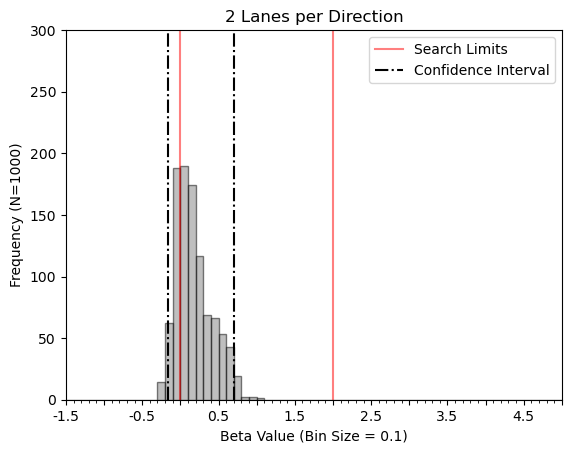

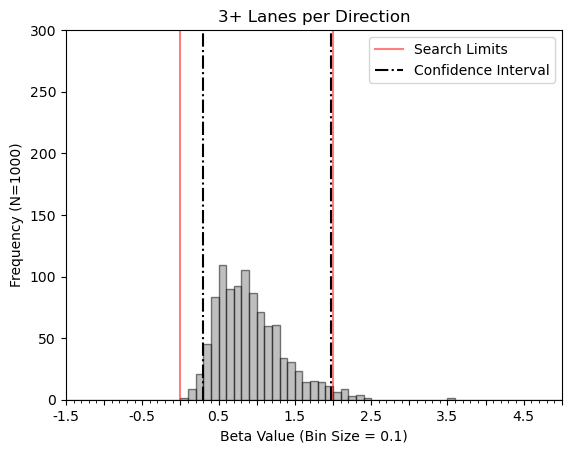

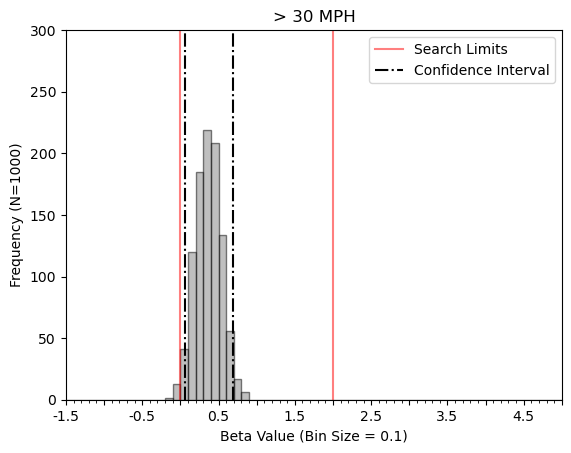

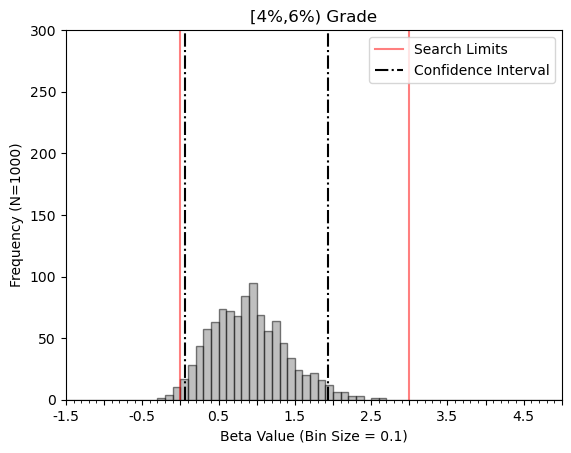

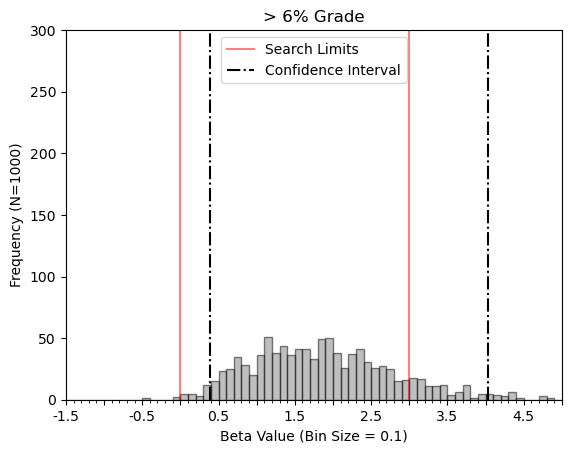

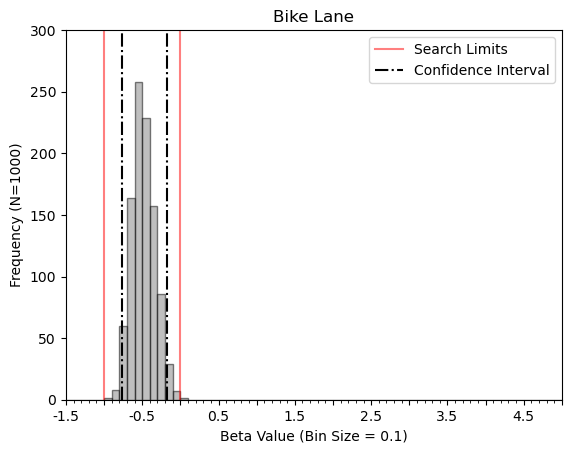

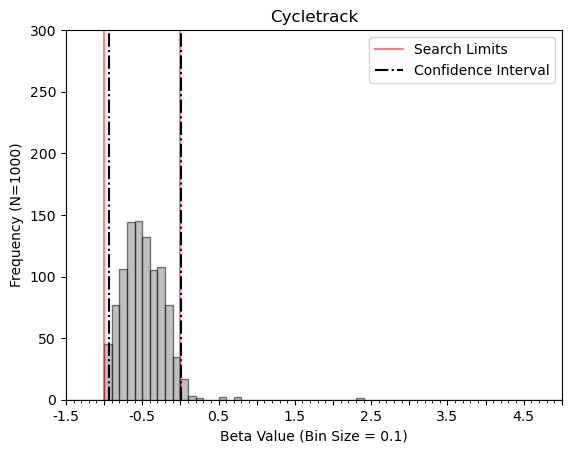

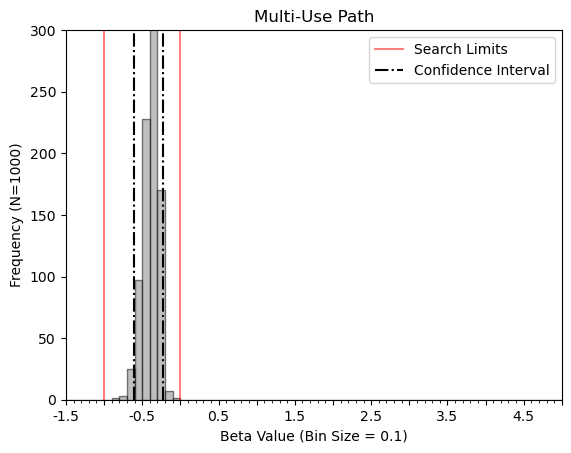

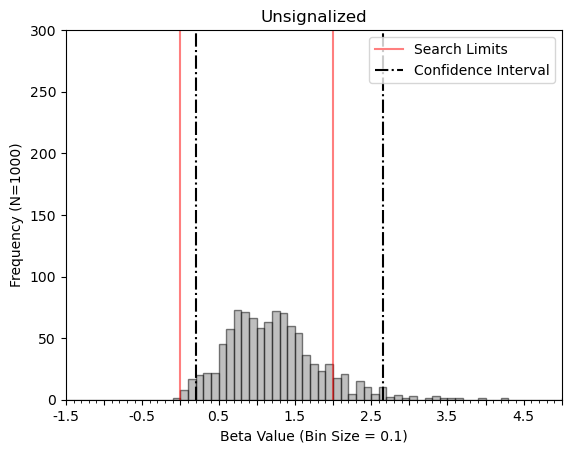

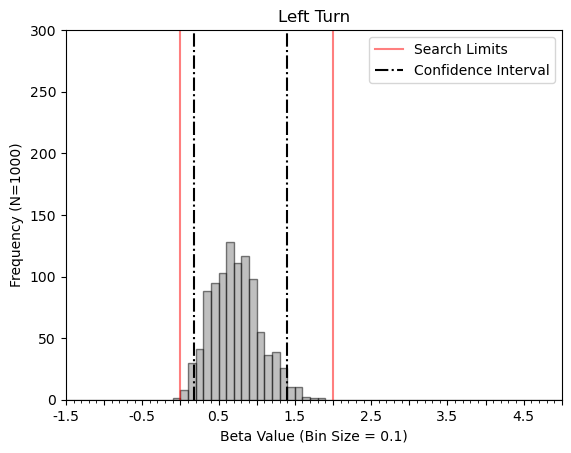

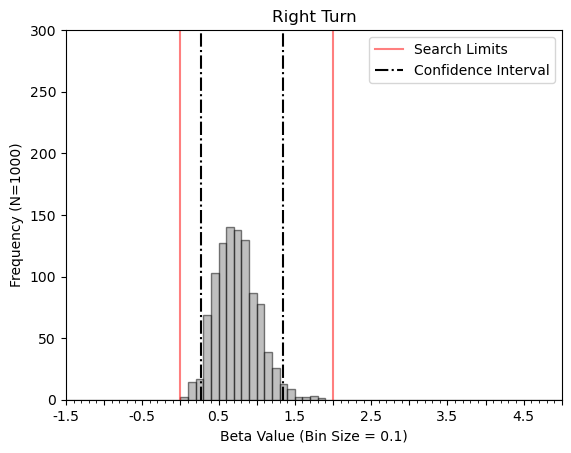

In [11]:
lower_bound_ci = lower_bound_ci.tolist()
upper_bound_ci = upper_bound_ci.tolist()

# Plot histogram for chosen_minus_modeled
min_val = np.floor(beta_vals[betas].min().min()) - 1
max_val = np.ceil(beta_vals[betas].max().max()) + 1
bin_size = 0.1

for beta, left_lim, right_lim, left_ci, right_ci in zip(betas,left_limit_lst,right_limit_lst,lower_bound_ci,upper_bound_ci):
    fig, ax = plt.subplots()

    ax.hist(beta_vals[beta], bins=np.arange(min_val, max_val + bin_size, bin_size), alpha=0.5, color='grey', label=None, edgecolor='Black')
    ax.set_title(beta_labels[beta])
    ax.set_xlabel(f'Beta Value (Bin Size = {bin_size})')
    ax.set_ylabel(f'Frequency (N={beta_vals.shape[0]})')
    ax.set_xlim(-1.5,5)
    # ax.set_xlim(min_val,max_val)
    ax.set_ylim(0,300)

    # search limits
    ax.axvline(x=left_lim, color='red', linestyle='solid', alpha=0.5, label = 'Search Limits')
    ax.axvline(x=right_lim, color='red', alpha=0.5, linestyle='solid')

    # # confidence intervals
    ax.axvline(x=left_ci, color='black', linestyle='dashdot', label = 'Confidence Interval')
    ax.axvline(x=right_ci, color='black', linestyle='dashdot')

    # Set major ticks every 0.5 and minor ticks every 0.1
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))

    # Optionally, customize the tick labels if you need only certain major ticks labeled
    ax.set_xticklabels([f"{tick:.1f}" if i % 2 == 1 else '' for i, tick in enumerate(ax.get_xticks())])

    # TODO add legend that has the confidence interval labels
    ax.legend()

    # Add vertical lines for the search limits
    plt.savefig(config['figures_fp']/f"{beta.replace(' ','_')}_bootstrap_dist.png",dpi=300)

## Histogram of Objective Function Values

In [ ]:
bootstrap_loss_vals = loss_vals[loss_vals['subset'].str.contains('bootsample')]
min_val = np.floor(bootstrap_loss_vals['jaccard_buffer_mean'].min() * 10) / 10
max_val = np.ceil(bootstrap_loss_vals['jaccard_buffer_mean'].max() * 10) / 10
bin_size = 0.005

left_ci = bootstrap_loss_vals['jaccard_buffer_mean'].quantile((1-confidence) / 2)
right_ci = bootstrap_loss_vals['jaccard_buffer_mean'].quantile(1 - ((1-confidence) / 2))
# left_tail = bootstrap_loss_vals['jaccard_buffer_mean'].quantile((1-confidence))
print(f"Mean:",bootstrap_loss_vals['jaccard_buffer_mean'].mean())
print(f"Standard Deviation:",bootstrap_loss_vals['jaccard_buffer_mean'].std())
print(f"Median:",bootstrap_loss_vals['jaccard_buffer_mean'].median())
print(f"Confidence Interval: [{left_ci:.2f},{right_ci:.2f}]")
# print(f"Left Tail: {left_tail:.2f}")

fig, ax = plt.subplots()
ax.hist(bootstrap_loss_vals['jaccard_buffer_mean'],bins=np.arange(min_val,max_val+bin_size,bin_size), alpha=0.5, color='grey', label=None, edgecolor='Black')
ax.set_xlabel(f'Jaccard Buffer Mean (Bin Size = {bin_size})')
ax.set_ylabel(f'Frequency (N={beta_vals.shape[0]})')

# confidence intervals
ax.axvline(x=left_ci, color='black', linestyle='dashdot', label = 'Confidence Interval')
ax.axvline(x=right_ci, color='black', linestyle='dashdot')

# Set major ticks every 0.5 and minor ticks every 0.1
ax.xaxis.set_major_locator(MultipleLocator(0.01))
ax.xaxis.set_minor_locator(MultipleLocator(0.005))

ax.yaxis.set_major_locator(MultipleLocator(25))
ax.yaxis.set_minor_locator(MultipleLocator(5))

# TODO add legend that has the confidence interval labels
ax.legend()

plt.savefig(config['figures_fp']/f"bootstrap_jaccard_buffer.png",dpi=300)

## Routing with the mean betas

In [ ]:
# bootstrap_loss_valsloss_vals[loss_vals['subset']=='bootstrap_final'
dissag = post_calibration.post_calibration_disaggregate()

In [ ]:
bootstrap_loss = dissag.loc[:,(dissag.columns.get_level_values(0) == 'bootstrap_final') & (dissag.columns.get_level_values(3) == 'jaccard_buffer')].dropna()
bootstrap_loss = bootstrap_loss.droplevel([0,1,2],axis=1)
# get the shortest ones
shortest_disaggregate = post_calibration.shortest_disaggregate()
shortest_disaggregate = shortest_disaggregate[shortest_disaggregate.index.isin(bootstrap_loss.index.tolist())]

## Make overlap histogram

In [ ]:
print('Mean Modeled',round(bootstrap_loss['jaccard_buffer'].mean(),2),'Mean Shortest',round(shortest_disaggregate['shortest_jaccard_buffer'].mean(),2))

bin_size = 0.05
bins = np.arange(0,1+bin_size,bin_size)

# make figures
# Create the histogram
fig, ax = plt.subplots()
ax.hist(shortest_disaggregate['shortest_jaccard_buffer'], bins=bins, alpha=0.5, label='Shortest', color='grey')
ax.hist(bootstrap_loss['jaccard_buffer'], bins=bins, alpha=0.3, label='Calibrated', color='blue')

# Adding labels, title, and legend with font size adjustments
ax.set_xlabel('Jaccard Index Buffer')
ax.set_ylabel(f'Frequency (N={bootstrap_loss.shape[0]})')
ax.legend()
ax.set_ylim([0,100])

# # Adjusting the font size of the tick labels
# plt.xticks(fontsize=22)
# plt.yticks(fontsize=22)

# Set major ticks every 0.5 and minor ticks every 0.1
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))

# Show the plot
# plt.savefig(config['figures_fp']/'bootstrap_overlap_hist.png',dpi=300)

In [ ]:
print('Mean Modeled',round(bootstrap_loss['jaccard_buffer'].mean(),2),'Mean Shortest',round(shortest_disaggregate['shortest_jaccard_buffer'].mean(),2))

bin_size = 0.05
bins = np.arange(-1,1+bin_size,bin_size)

# make figures
# Create the histogram
fig, ax = plt.subplots()
ax.hist(bootstrap_loss['jaccard_buffer'] - shortest_disaggregate['shortest_jaccard_buffer'], bins=bins, alpha=0.5, label='Calibrated - Shortest', color='grey')
# ax.hist(bootstrap_loss['jaccard_buffer'], bins=bins, alpha=0.3, label='Calibrated', color='blue')

# Adding labels, title, and legend with font size adjustments
ax.set_xlabel('Delta Jaccard Index Buffer')
ax.set_ylabel(f'Frequency (N={bootstrap_loss.shape[0]})')
ax.legend()
ax.set_ylim([0,150])

# # Adjusting the font size of the tick labels
# plt.xticks(fontsize=22)
# plt.yticks(fontsize=22)

# Set major ticks every 0.5 and minor ticks every 0.1
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

# Show the plot
# plt.savefig(config['figures_fp']/'bootstrap_overlap_diff_hist.png',dpi=300)

In [ ]:
improved = bootstrap_loss[bootstrap_loss['jaccard_buffer'] - shortest_disaggregate['shortest_jaccard_buffer'] > 0]
improved

In [ ]:
no_change = bootstrap_loss[bootstrap_loss['jaccard_buffer'] - shortest_disaggregate['shortest_jaccard_buffer'] == 0]
no_change

In [ ]:
worse = bootstrap_loss[bootstrap_loss['jaccard_buffer'] - shortest_disaggregate['shortest_jaccard_buffer'] < 0]
worse

## Validation on holdout trips
Find the least impedance path on the rest of the trips.

In [ ]:
with (config['calibration_fp']/'subsets.pkl').open('rb') as fh:
    subset = pickle.load(fh)
subset = [x for x in subset if 'random' == x[0]][0][1]
with (config['calibration_fp']/'ready_for_calibration.pkl').open('rb') as fh:
    match_results = pickle.load(fh)

In [ ]:
bootstrap_final_fp = config['calibration_fp'] / 'results/bootstrap_final,validation,0.pkl'
holdout = [(bootstrap_final_fp,list(set(list(match_results.keys())) - set(subset)))]
print(len(holdout[0][1]),'trips in the holdout sample')

In [ ]:
# run this to run shortest paths on the holdout sample
post_calibration.validation_workflow(holdout)

In [ ]:
# how to import the results
shortest_disaggregate = post_calibration.shortest_disaggregate()
shortest_disaggregate = shortest_disaggregate[shortest_disaggregate.index.isin(holdout[0][1])]
shortest_disaggregate['shortest_jaccard_buffer'].mean()

In [ ]:
testing_loss_vals = post_calibration.testing_aggregated_loss_dataframe()
testing_loss_vals = testing_loss_vals[testing_loss_vals['subset']=='bootstrap_final']

In [ ]:
testing_loss_vals

In [ ]:
# # import network
# links, turns, length_dict, geo_dict, turn_G = rustworkx_routing_funcs.import_calibration_network(config)

# # import matched traces (all of them at first)
# with (config['calibration_fp']/'ready_for_calibration.pkl').open('rb') as fh:
#     match_results = pickle.load(fh)
# with (config['calibration_fp']/'subsets.pkl').open('rb') as fh:
#     subset = pickle.load(fh)
# subset = [x for x in subset if 'random' == x[0]][0][1]

# # subset to a user's trips if user argument is provided
# match_results = {tripid:item for tripid, item in match_results.items() if tripid in subset}
# ods = utils.match_results_to_ods_w_year(match_results)
# betas = [x['beta'] for x in bootstrap_model['betas_tup']] # get betas

# # for backwards compatibility
# # these only just now got added to the bootstrap_model dictionary 
# if bootstrap_model.get('link_impedance_function') is None:
#     bootstrap_model['link_impedance_function'] = impedance_functions.link_impedance_function
# if bootstrap_model.get('turn_impedance_function') is None:
#     bootstrap_model['turn_impedance_function'] = impedance_functions.turn_impedance_function
# if bootstrap_model.get('base_impedance_col') is None:
#     bootstrap_model['base_impedance_col'] = 'travel_time_min'
# if bootstrap_model.get('base_link_col') is None:
#     bootstrap_model['base_link_col'] = None

# #PROBLEM, need the impedance function used
# modeled_dict = stochastic_optimization.impedance_routing(
#     betas,
#     bootstrap_model['betas_tup'],
#     bootstrap_model['link_impedance_function'],
#     bootstrap_model['base_impedance_col'],
#     bootstrap_model['base_link_col'],       
#     bootstrap_model['turn_impedance_function'],
#     links,
#     turns,
#     turn_G,
#     ods,
#     bootstrap_model['set_to_zero'],
#     bootstrap_model['set_to_inf']
#     )

# loss_dict = {}
# # we could try storing these
# for tripid, item in match_results.items(): # make sure you import this
#     skip = False            
    
#     chosen = item['matched_edges'].values
#     shortest = item['shortest_edges'].values
    
#     # NOTE one limitation of this is that if the origin node and destination node change at any point then
#     # than this step will break
#     od = (item['origin_node'],item['destination_node'])
#     modeled = modeled_dict.get(od)
#     if modeled is None:
#         # print(f"Missing shortest paths in calibration {loss_stem}")
#         skip = True
#         break
#     modeled = modeled['edge_list']

#     #compute the loss values (store the intermediates too so total vs mean methods can be compared)
#     modeled_jaccard_exact_intersection, modeled_jaccard_exact_union =  loss_functions.jaccard_exact(chosen,modeled,length_dict)
#     modeled_jaccard_exact = modeled_jaccard_exact_intersection / modeled_jaccard_exact_union
#     modeled_jaccard_buffer_intersection, modeled_jaccard_buffer_union =  loss_functions.jaccard_buffer(chosen,modeled,geo_dict)
#     modeled_jaccard_buffer = modeled_jaccard_buffer_intersection / modeled_jaccard_buffer_union

#     loss_dict[tripid] = {
#         'modeled_edges': pd.DataFrame(modeled,columns=['linkid','reverse_link']),
#         'modeled_length': round(np.array([length_dict.get(tripid[0],0) for tripid in modeled]).sum()/5280,1),
#         'modeled_detour': round(loss_functions.detour_factor(modeled,shortest,length_dict),2),
#         'modeled_jaccard_exact': round(modeled_jaccard_exact,2),
#         'modeled_jaccard_exact_intersection': round(modeled_jaccard_exact_intersection,2),
#         'modeled_jaccard_exact_union': round(modeled_jaccard_exact_union,2),
#         'modeled_jaccard_buffer': round(modeled_jaccard_buffer,2),
#         'modeled_jaccard_buffer_intersection': round(modeled_jaccard_buffer_intersection,2),
#         'modeled_jaccard_buffer_union': round(modeled_jaccard_buffer_union,2),
#     }

# bootstrap_loss = pd.DataFrame().from_dict(loss_dict,orient='index')
# bootstrap_loss['modeled_jaccard_buffer']

In [ ]:
## For looking at the difference in route attributes
# import matplotlib.pyplot as plt

# # Define the number of columns to plot
# columns = chosen_minus_modeled.columns  # Assuming both DataFrames have the same columns
# num_columns = len(columns)

# # Set up the figure and subplots
# fig, axes = plt.subplots(num_columns, 1, figsize=(10, 100))

# # Loop through each column and create a histogram
# for i, column in enumerate(columns):
#     # Plot histogram for chosen_minus_modeled
#     axes[i].hist(chosen_minus_modeled[column].round(2), bins=50, alpha=0.5, color='blue', label='Chosen Minus Modeled', edgecolor='black')

#     # Plot histogram for chosen_minus_shortest
#     axes[i].hist(chosen_minus_shortest[column].round(2), bins=50, alpha=0.5, color='orange', label='Chosen Minus Shortest', edgecolor='black')

#     # Set the title and labels for each subplot
#     axes[i].set_title(f'Histogram for {column}')
#     axes[i].set_ylabel('Frequency')
    
#     # Center the histograms around zero by setting limits
#     max_val = max(chosen_minus_modeled[column].max(), chosen_minus_shortest[column].max())
#     min_val = min(chosen_minus_modeled[column].min(), chosen_minus_shortest[column].min())
#     val = max(abs(max_val),abs(min_val))

#     axes[i].set_xlim(min(val * -1, -1), max(val, 1))  # Adjust these limits based on your data

#     # Add gridlines for better readability
#     axes[i].grid(True)

#     axes[i].legend()

# # Set a common xlabel
# axes[-1].set_xlabel('Value')

# # Add a legend to the last subplot
# # axes[-1].legend()

# # Show the plot
# plt.tight_layout()  # Adjust subplots to fit in the figure area.
# plt.show()
